In [1]:
import os
os.chdir('..')

In [6]:
import logging
import os
import h5py
import numpy as np
from pathlib import Path
from typing import Union, List, Callable

import tensorflow as tf
import torch as th
from torch.utils.data import Dataset


class TorchCIFAR100Fed(Dataset):
    N_ELEMENTS_PER_CLIENT = 100

    def __init__(self, split: Union[str, List[str]], transform: Callable = None):
        download_all_data()
        self.images, self.labels = get_data(split)
        self.transform = transform

        if self.transform is not None:
            self.images = th.tensor(
                np.stack(
                    [
                        self.transform(self.images[i,])
                        for i in range(self.images.shape[0])
                    ]
                )
            )

        self.images.cuda()

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        return self.images[idx, ], self.labels[idx, ]


def download_all_data():
    data_dir = Path("data/cifar100fed")
    is_extract = not data_dir.exists()
    if not is_extract:
        return

    logging.info(f"Data extration: {is_extract} ...")

    path = tf.keras.utils.get_file(
        "fed_cifar100.tar.bz2",
        origin="https://storage.googleapis.com/tff-datasets-public/fed_cifar100.tar.bz2",
        file_hash="e8575e22c038ecef1ce6c7d492d7abee7da13b1e1ba9b70a7fc18531ba7590de",
        hash_algorithm="sha256",
        extract=True,
        archive_format="tar",
    )
    logging.info(f"Data extrated")
    
    dir_path = os.path.dirname(path)

    def download_split(data_set):
        split_dir = data_dir / data_set
        try:
            os.makedirs(split_dir)
        except FileExistsError:
            return
        h5 = h5py.File(os.path.join(dir_path, f"fed_cifar100_{data_set}.h5"), "r")[
            "examples"
        ]

        for client_id in h5.keys():
            images = []
            labels = []
            for item_id in range(100):
                images.append(h5[client_id]["image"][item_id])
                labels.append(h5[client_id]["label"][item_id])
            images = np.stack(images, axis=0)
            labels = np.stack(labels, axis=0)
            np.save(split_dir / f"{client_id}_img", images)
            np.save(split_dir / f"{client_id}_label", labels)

    download_split("train")
    download_split("test")


def get_data(split):
    if isinstance(split, str) and split == "test":
        data_set = "test"
        client_ids = [str(i) for i in range(100)]
    else:
        data_set = "train"
        client_ids = split

    images = []
    labels = []
    for c in client_ids:
        i, l = get_client_data(data_set, c)
        images.append(i)
        labels.append(l)

    return np.concatenate(images), np.concatenate(labels)


def get_client_data(data_set, client_id):
    data_dir = Path("data/cifar100fed")
    split_dir = data_dir / data_set

    images = np.load(split_dir / f"{client_id}_img.npy")
    labels = np.load(split_dir / f"{client_id}_label.npy")
    return images, labels


In [7]:
from torchvision import transforms
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
ds = TorchCIFAR100Fed(["2"], transform)

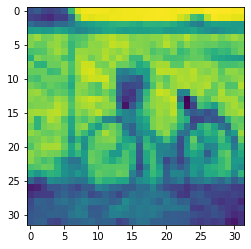

In [11]:
import matplotlib.pyplot as plt
plt.imshow(ds[0][0][0,])